In [1]:
!wget -nc 140.114.76.113:8000/pA1.csv
!wget -nc 140.114.76.113:8000/pA2.csv

File ‘pA1.csv’ already there; not retrieving.

File ‘pA2.csv’ already there; not retrieving.



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [0]:
seed = 999
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
# Set up variables
batch_size = 1
# test_split = .3
shuffle_dataset = False

In [0]:
class Data(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor(ann['x'])
        y = torch.tensor(ann['y'])
        return x, y

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(1) * 0.001)
        self.b = nn.Parameter(torch.rand(1) * 0.001)
    
    def forward(self, xs):
        ps = self.a * xs + self.b
        return ps

In [0]:
# Load dataset
data = Data('./pA1.csv')
dataloader = DataLoader(data, batch_size=batch_size)

In [0]:
# For plotting
scatter_x = []
scatter_y = []
for i in data:
    scatter_x.append(i[0])
    scatter_y.append(i[1])
scatter_x = np.asarray(scatter_x)
scatter_y = np.asarray(scatter_y)

In [0]:
# device = 'cpu'
model = Net().to(device)
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

0%--------------------100%
 |--------------------|
Finish Training!


Text(0, 0.5, 'loss')

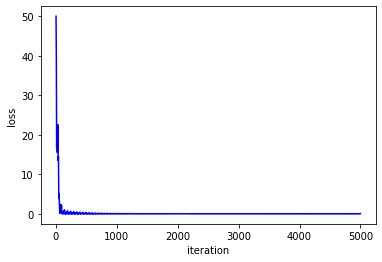

In [12]:
show_iter = 50
# EPOCH = 2000
EPOCH = 100
# show_epoch = 50
show_epoch = 5

history = {
    'loss': [],
    'a': [],
    'b': []
}

loss_plot = {
    'iter': [],
    'loss': []
}

# Plot progress bar
print('0%', end='')
for i in range(int(EPOCH/show_epoch)):
    print('-', end='')
print('100%')
print(' |', end='')

i=0
for epoch in range(EPOCH):
    for xs, ys in iter(dataloader):
        i+=1
        xs = xs.to(device)
        ys = ys.to(device)

        optimizer.zero_grad()
        ps = model(xs)
        loss = criterion(ps, ys)
        loss.backward()
        optimizer.step()
        
        if i % show_epoch == (show_epoch-1):
            history['loss'].append(loss.detach().item())
            history['a'].append(model.a.item())
            history['b'].append(model.b.item())
        
            loss_plot['iter'].append(i)
            loss_plot['loss'].append(loss.detach().item())
    
    if epoch % show_epoch == (show_epoch-1):
        print('-',end='')

print("|\nFinish Training!")
plt.plot(np.array(loss_plot['iter']),
         np.array(loss_plot['loss']), 'b')
plt.xlabel("iteration")
plt.ylabel("loss")

In [13]:
print("y = %.3fx + %.3f" % (model.a, model.b))

y = 5.029x + 3.983


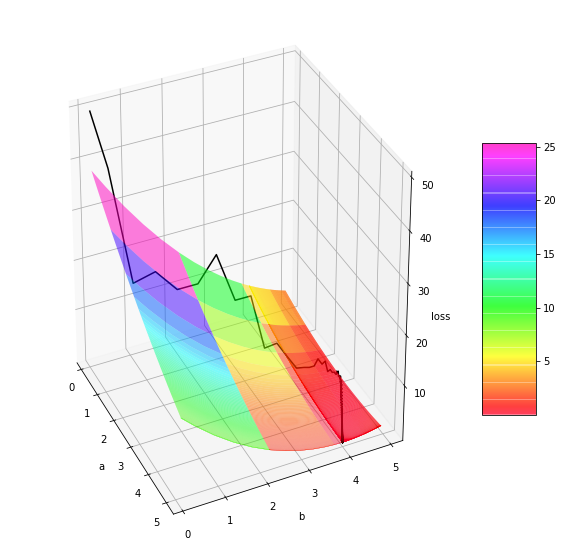

In [14]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

plot_x = np.array(history['a'])
plot_y = np.array(history['b'])
plot_z = np.array(history['loss'])
ax.plot3D(plot_x, plot_y, plot_z, c='black')

surface_x, surface_y = np.meshgrid(plot_x, plot_y)

F = np.zeros((surface_x.shape[0], surface_y.shape[1]))
for x, y in iter(dataloader):
    x = np.array(x)
    y = np.array(y)
    y_p = surface_x*x+surface_y
    loss = ((y_p-y)**2)
    F += loss
F = F / len(dataloader)

surf = ax.plot_surface(surface_x, surface_y, F, rstride=5, cstride=5,
                       alpha=0.5, cmap=plt.get_cmap('gist_rainbow'))

# rotate the axes
ax.view_init(30, 335)

ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("loss")
fig.colorbar(surf, shrink=0.5, aspect=5)

Text(0, 0.5, 'y')

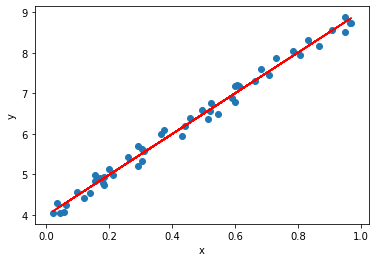

In [15]:
a = model.a.detach().cpu().numpy()
b = model.b.detach().cpu().numpy()
plt.scatter(scatter_x, scatter_y)
plt.plot(scatter_x, (a*scatter_x+b), 'r-')
plt.xlabel("x")
plt.ylabel("y")

In [0]:
class Data2(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor([ann['x']**2, ann['x']])
        y = torch.tensor(ann['y'])
        return x, y

In [0]:
class Net2(nn.Module):
    def __init__(self, feature_in, feature_out):
        super().__init__()
        self.L1 = nn.Linear(feature_in, feature_out, bias=True)
    
    def forward(self, xs):
        xs = self.L1(xs)
        return xs

In [0]:
# Reset batch_size
batch_size = 5

# Load dataset
data2 = Data2('./pA2.csv')
dataloader2 = DataLoader(data2, batch_size=batch_size)

In [0]:
# For plotting
x2 = []
y2 = []
for i in data2:
    x2.append(i[0][1])
    y2.append(i[1])
x2 = np.asarray(x2)
y2 = np.asarray(y2)

In [0]:
model2 = Net2(2, 1).to(device)

In [0]:
criterion = nn.MSELoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.03, momentum=0.9)

0%------------------------------100%
 |------------------------------|
Finish Training!


Text(0, 0.5, 'loss')

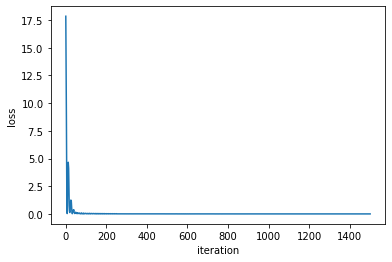

In [22]:
EPOCH = 150
show_epoch = 5

Plot = {
    'iter':[],
    'loss':[]
}

# Plot progress bar
print('0%', end='')
for i in range(int(EPOCH/show_epoch)):
    print('-', end='')
print('100%')
print(' |', end='')

iter_count = 0
for epoch in range(EPOCH):
    for xs, ys in iter(dataloader2):
        iter_count += 1
        xs = xs.to(device)
        ys = ys.to(device)
        ys = ys.view(-1,1)
        optimizer2.zero_grad()
        ps = model2(xs)
        loss = criterion(ps, ys)
        loss.backward()
        optimizer2.step()
        
        Plot['iter'].append(iter_count)
        Plot['loss'].append(loss.detach().item())
            
    if epoch % show_epoch == (show_epoch-1):
        print('-',end='')

print("|\nFinish Training!")

plt.plot(np.array(Plot['iter']), np.array(Plot['loss']))
plt.xlabel("iteration")
plt.ylabel("loss")

In [23]:
w0 = model2.L1.weight[0][0].detach().cpu().item()
w1 = model2.L1.weight[0][1].detach().cpu().item()
w2 = model2.L1.bias[0].detach().cpu().item()
print("y = %.3fx^2 + %.3fx + %.3f" % (w0, w1, w2))

y = -1.967x^2 + 0.978x + 3.997


Text(0, 0.5, 'y')

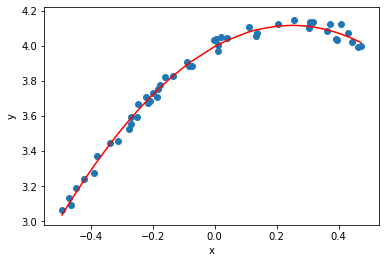

In [24]:
plt.scatter(x2, y2)
x_sort = np.sort(x2)
py = (w0 * (x_sort**2) + w1 * x_sort + w2)
plt.plot(x_sort, py, 'r-')
plt.xlabel("x")
plt.ylabel("y")